---
title:  "Monte-Carlo Integration made easy"
description: "A practical Python explanation of Monte-Carlo integration"
date: 2020-06-21
categories: [tutorial]
tags: [statistics]
aliases: ["/montecarlo"]
math: true
---
Integrating a function is tricky. A lot of the time, the math is beyond us. Or beyond me, at the very least, and so I turn to my computer, placing the burden on its silent, silicon shoulders. And yet this isn't the end of it, because there are a host of ways to perform numerical integration.

Do we want the simple rectangle rule? The superior trapezoidal rule? Simpson's rule? Do we want to adaptively sample? How many dimensions is this in anyway - 1D, 2D, 3D... 100D?

Unfortunately, every algorithm listed above falls over at higher dimensionality, simply because most of them are based off a grid. If you have a 100 points in a grid, for a 1D integral, thats easy, 100 points. For a 2D grid, well now its 10 thousand cells. For a 3D grid, thats a million voxels. This is exponential scaling. This is bad news.

So instead we turn to the amazing algorithm of Monte-Carlo integration. Monte-Carlo here means its based off random numbers (yes, I'm glossing over a lot), and so we perform Monte-Carlo integration essentially by just taking the average of our function after evaluating it at some random points.

Let's just illustrate this with an example, starting with Simpson's rule. Let's integrate the super simple function:

$$ \int_0^{1.5\pi} \sin(x) \ dx $$

In [1]:
# Remove
from base import *
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#50d460', '#dbce1a', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

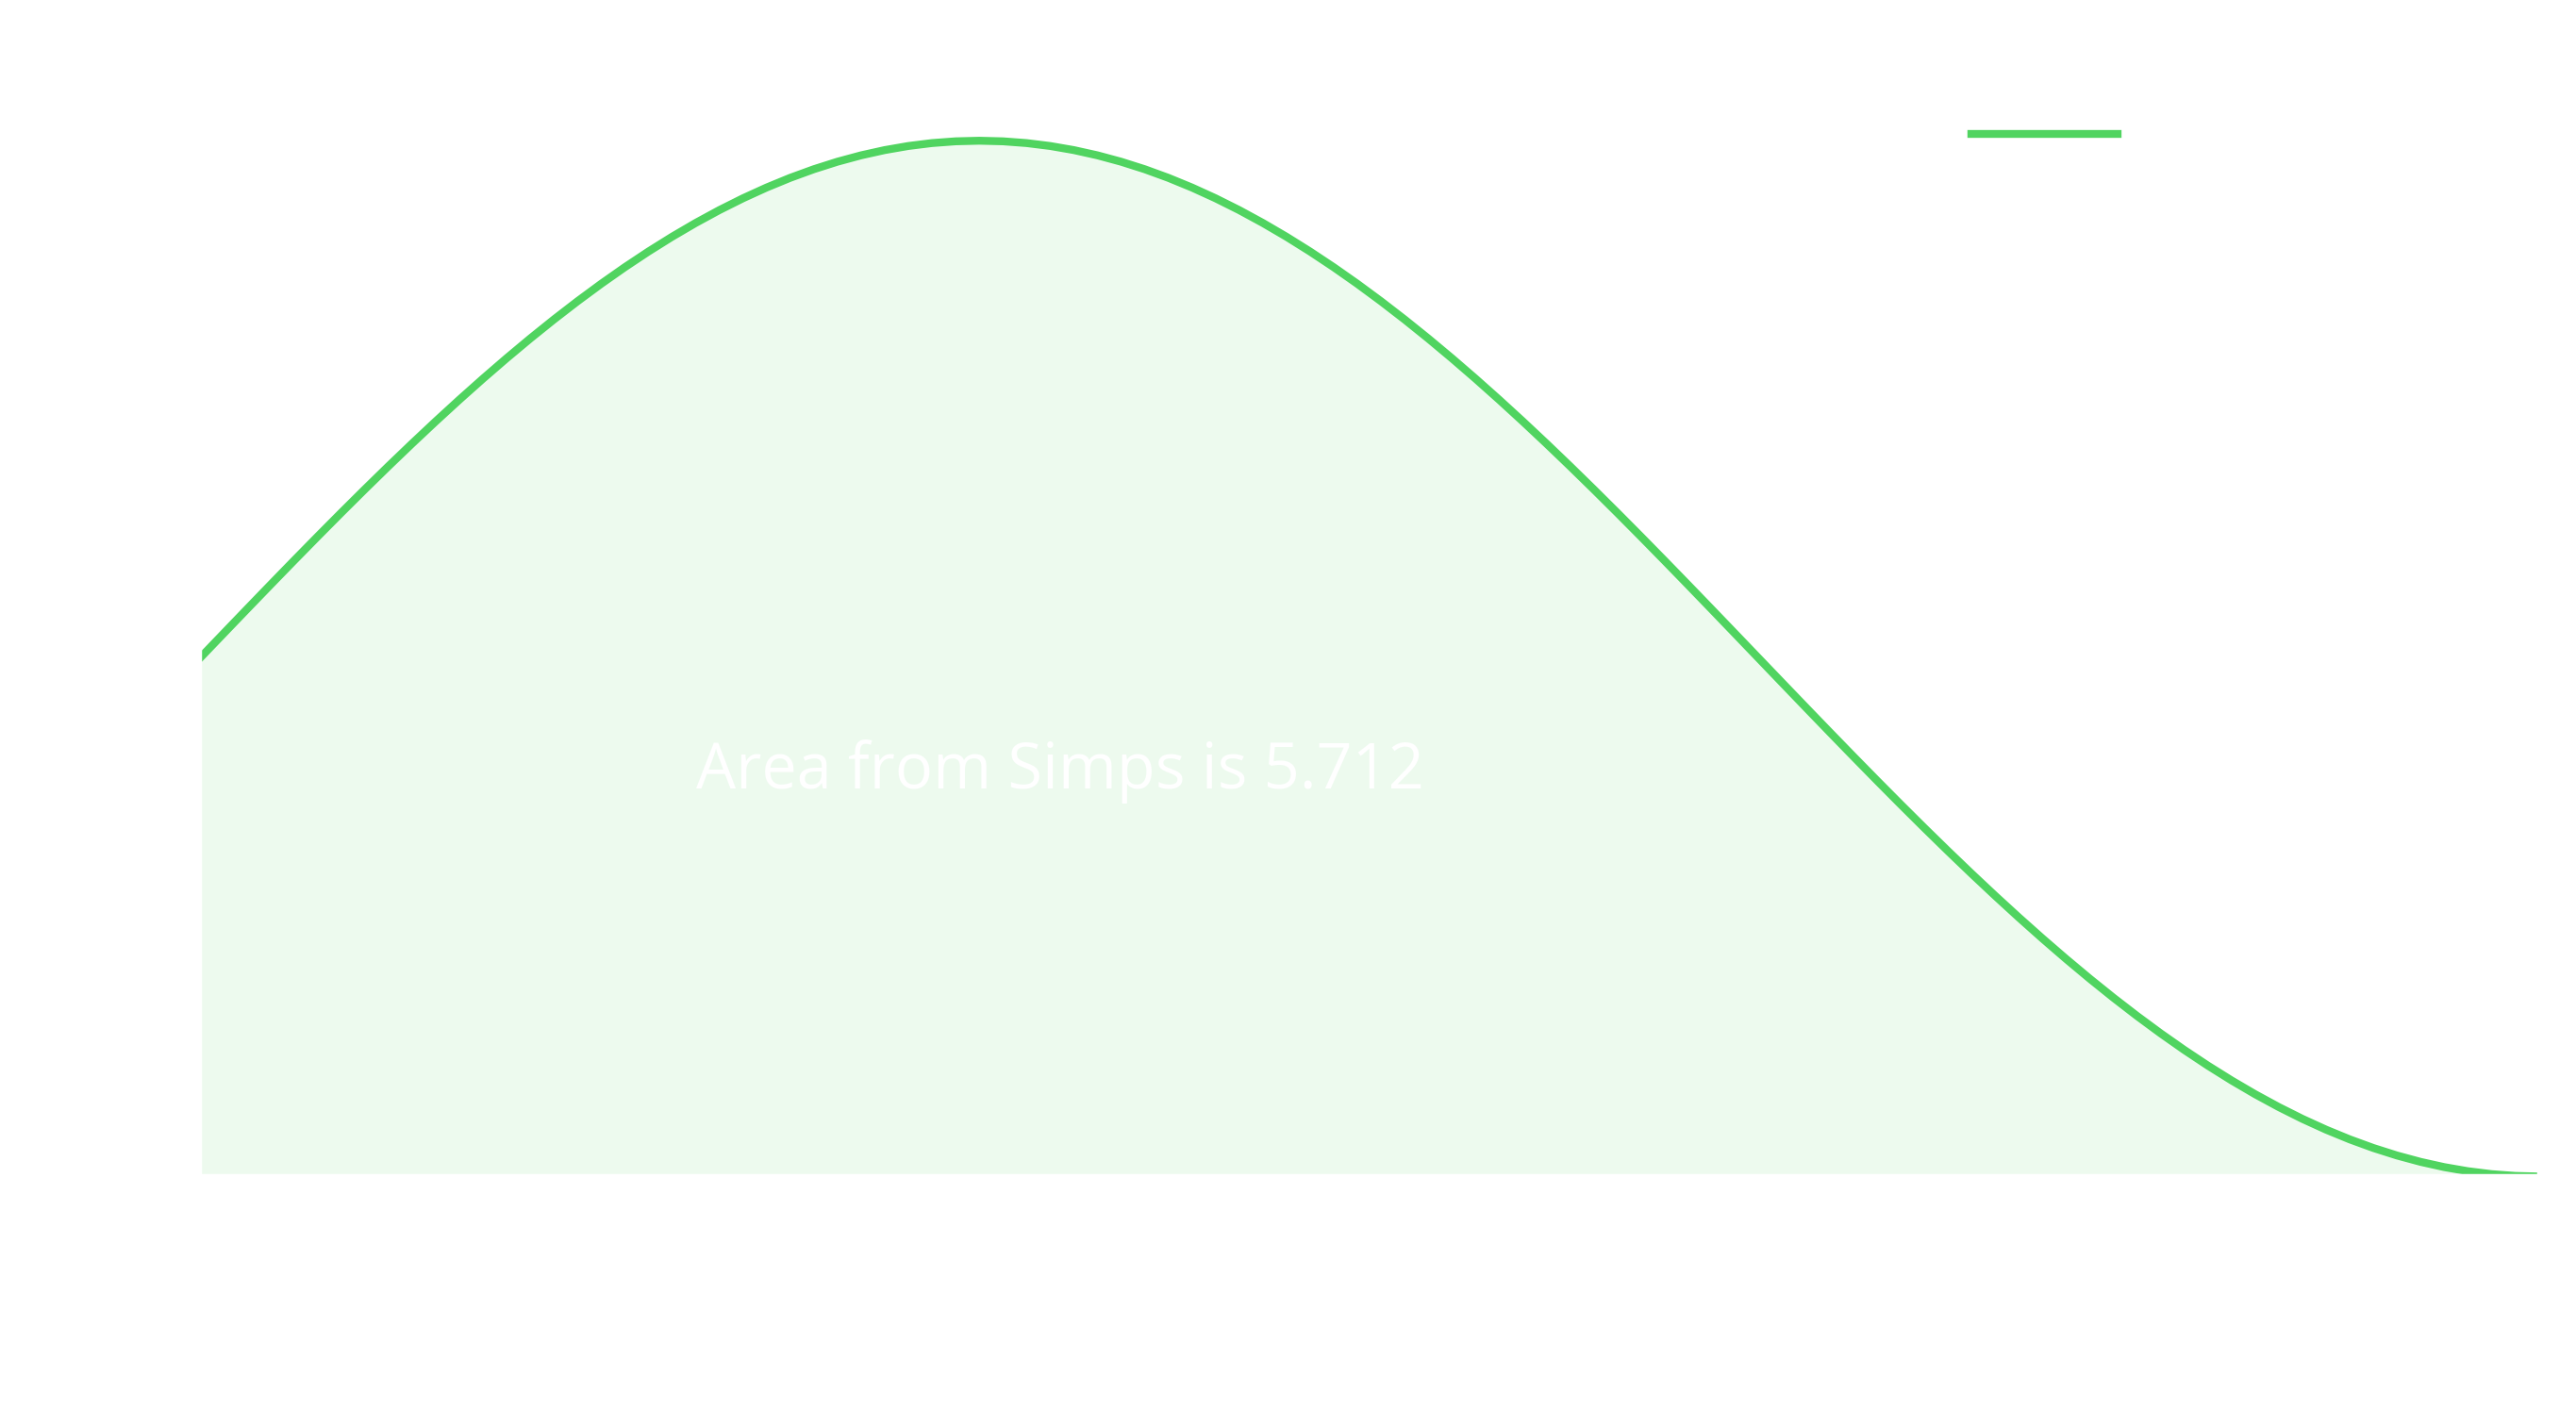

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps

def fn(x):
    return np.sin(x) + 1

xs = np.linspace(0, 1.5 * np.pi, 100)
ys = fn(xs)
area = simps(ys, x=xs)

plt.plot(xs, ys, label="Function")
plt.fill_between(xs, 0, ys, alpha=0.1)
plt.text(1, 0.75, f"Area from Simps is {area:0.3f}", fontsize=12)
plt.xlabel("x"), plt.legend();
plt.ylim(0, 2.2); ###REMOVE

Great, so how would we use Monte-Carlo integration to get another esimtate?

In [3]:
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#3ccfb4', '#dbce1a', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

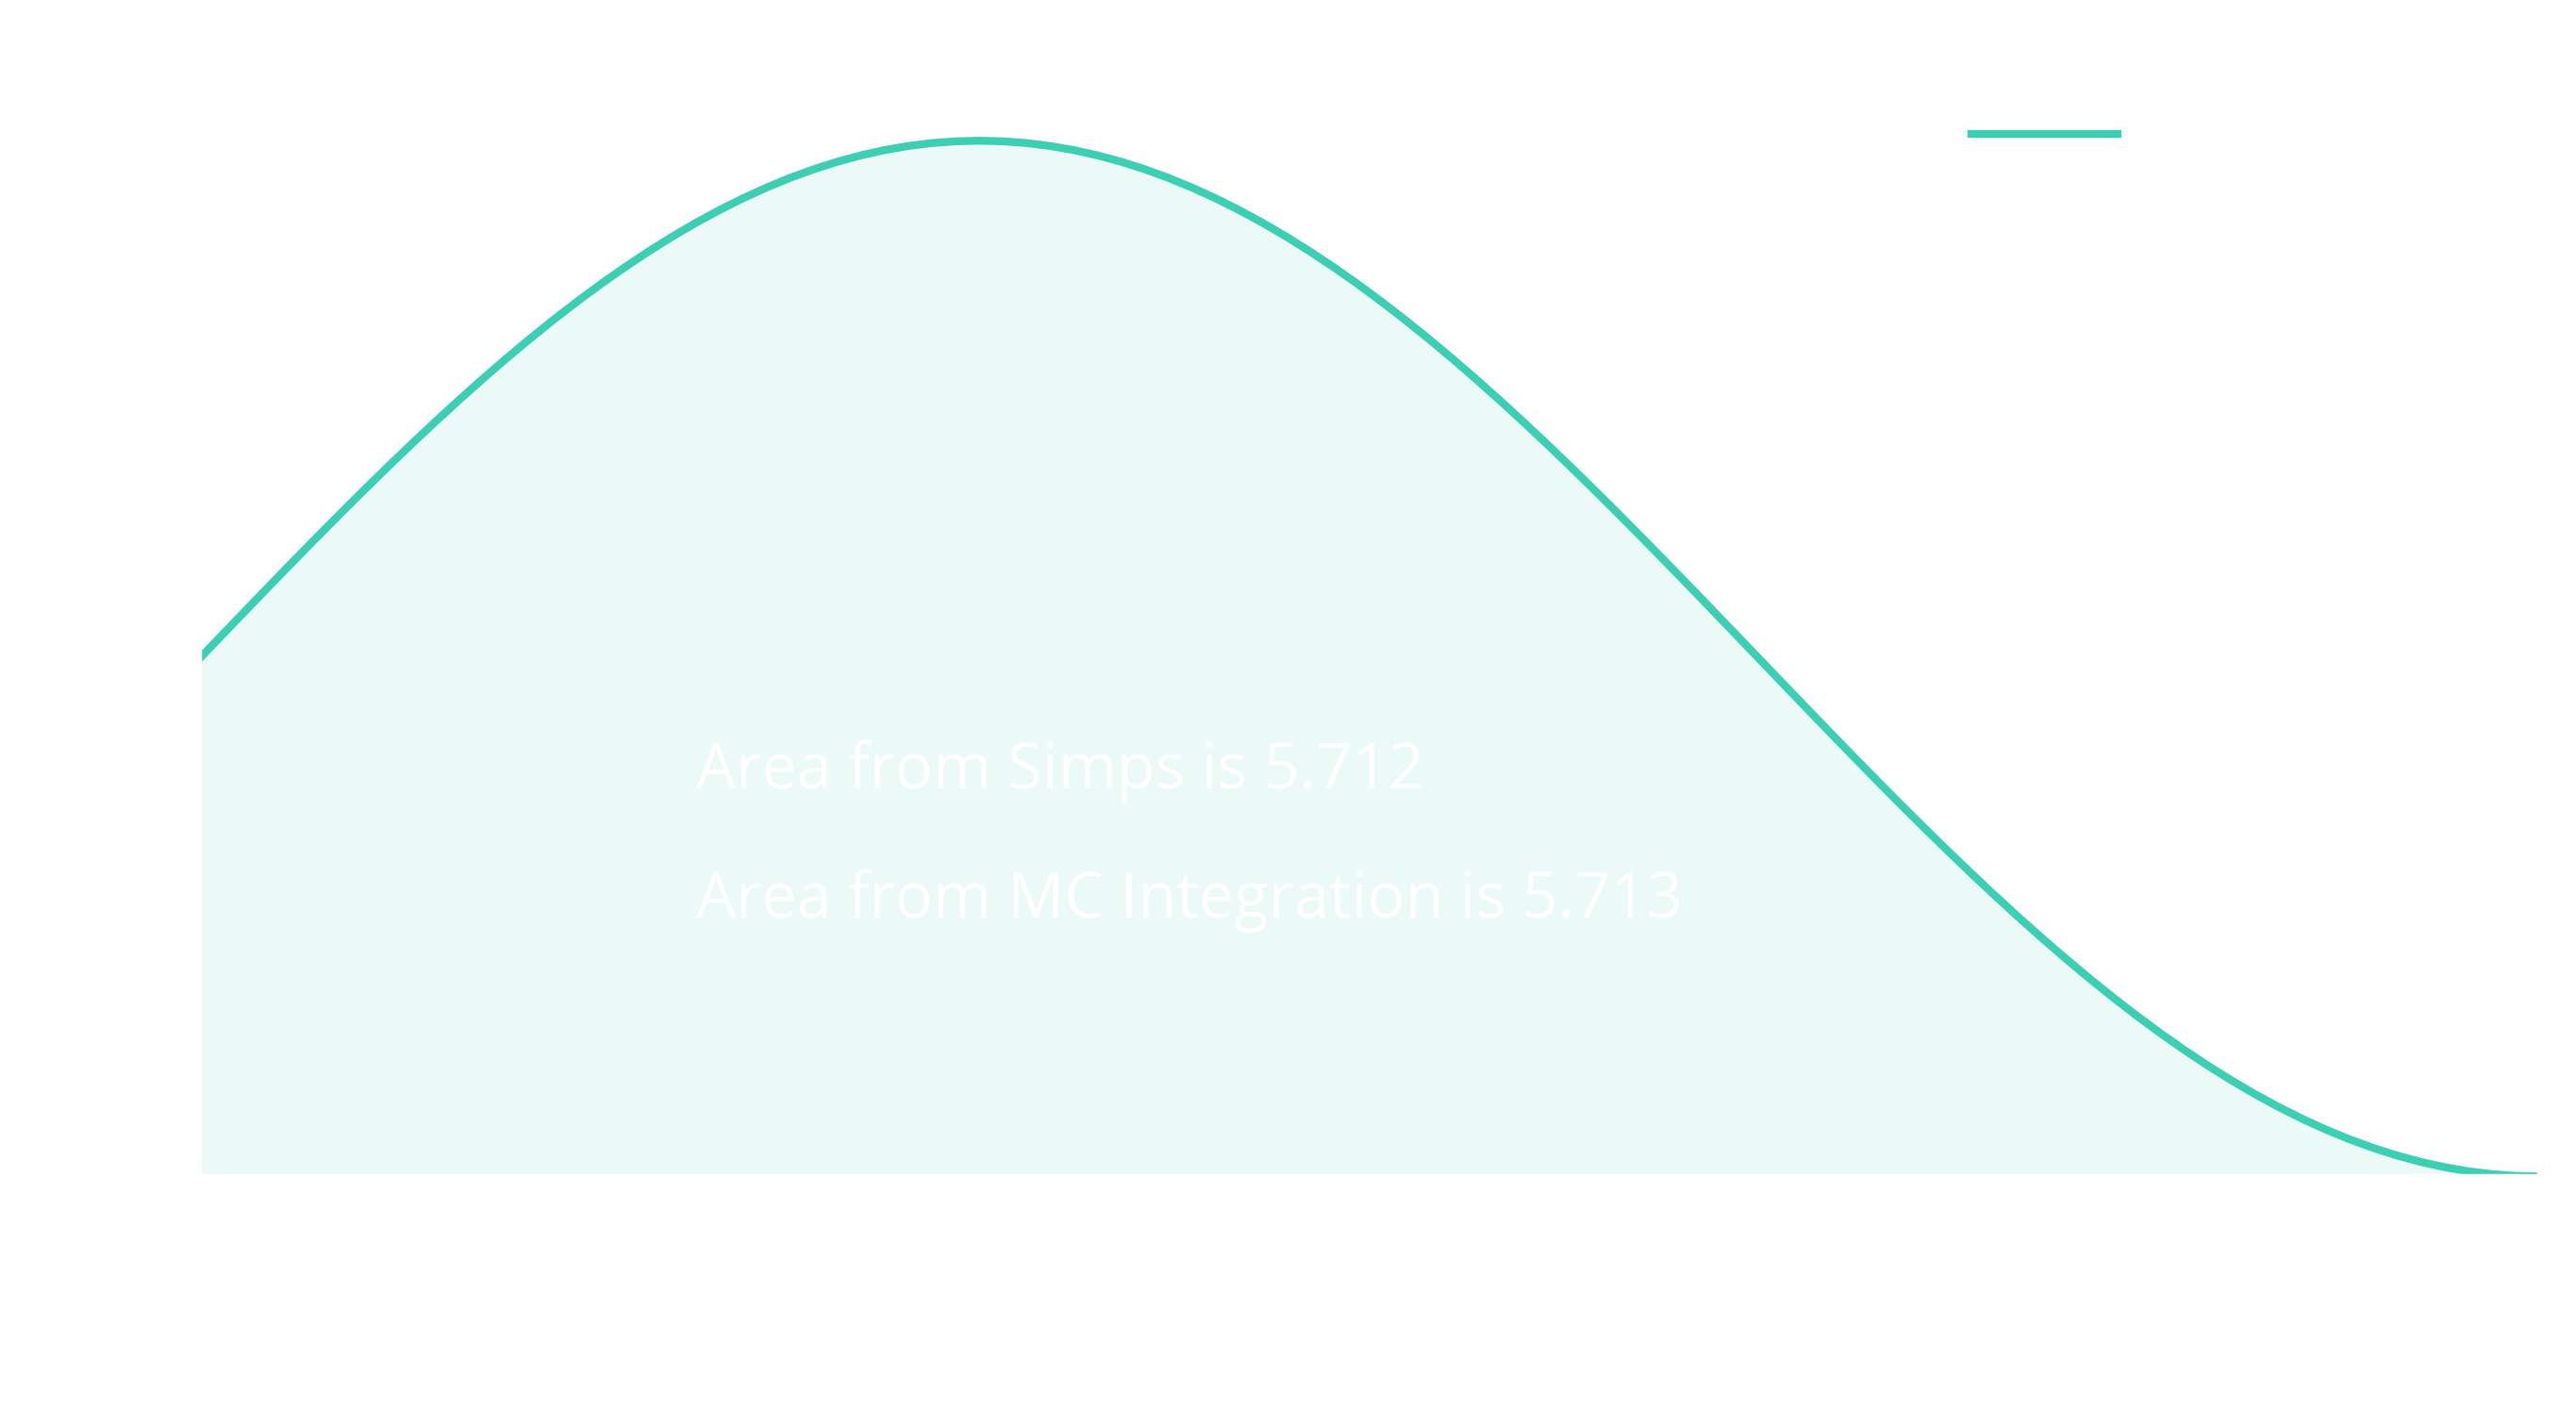

In [4]:
width = 1.5 * np.pi - 0  # The width from 0 to 1.5pi
samples = np.random.uniform(low=0, high=width, size=1000000)
mc_area = fn(samples).mean() * width

plt.plot(xs, ys, label="Function")
plt.fill_between(xs, 0, ys, alpha=0.1)
plt.text(1, 0.75, f"Area from Simps is {area:0.3f}", fontsize=12)
plt.text(1, 0.5, f"Area from MC Integration is {mc_area:0.3f}", fontsize=12)
plt.xlabel("x"), plt.legend();
plt.ylim(0, 2.2); ###REMOVE

Alright, so let's dig into this a bit:

1. Why does this work?
2. What is `width`?
3. Why did I have to ask for a million samples!?!?

Lets start with \#1: **How does this work?**

Monte-Carlo integration is all about that [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers). To summarise the Wiki page, the LLN states that if you do an experiment over and over, the average of your experiment should converge to the expected value. Our experiment here is "sampling the function (uniformly)", so the LLN says if we keep sampling it, the average result should converge to the mean of the function. This should be intuitive - if you roll a fair 6-sided die a lot and take an average, you'd expect that you'd get around the same amount of each number, which would give you an average of 3.5.

Let's merge in **What is `width`** now. If we have the average of a function over some arbitrary $x$-domain, to get the area we need to factor in how big that $x$-domain is. We are essentially finding the area of a rectangle `width` wide, with an average height given by our samples. 

If we want to be more formal about this, what we are doing is combining both our original function

$$ f(x) = \sin(x), $$

and the probability density function that describes how we draw our samples. In our case, this function is - in English - uniformly between $0$ and $1.5\pi$, and in mathematics:

$$p(x) = 
    \begin{cases}
      \frac{1}{1.5\pi}, & \text{if}\ 0 < x < 1.5\pi \\
      0, & \text{otherwise}
    \end{cases}$$

The "width" comes in to our final result when you add the probability in to our equation:

$$\begin{align}\int_0^{1.5\pi} \sin(x)\ dx &= \int_0^{1.5\pi} \sin(x)\ \  \frac{1.5\pi}{1.5\pi} \ dx\\
&= \int_0^{1.5\pi}  1.5\pi\sin(x)   \ \ p(x) \ dx
\end{align}$$

Sorry for the math, but hopefully you can see that if we separate the equation so that we can get our sample function on the right, the `width` factor comes out naturally. Conceptually, it's easier to think of it using the rectangle analogy above, but that doesn't generalise too well.

Finally, **why did we need so many samples?**

The answer is that I wanted to make sure it agreed very well with the result from Simpsons' rule. Monte-Carlo integration has uncertainty, but you can quantify that:

$$ \text{error} = \frac{\sigma(x)}{\sqrt{N}}$$

where $\sigma$ is the standard deviation, $x$ is what we average (so really our samples times our width), and $N$ is the number of points. For us, the plot should really look like this:

In [5]:
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#1ca7e8', '#dbce1a', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

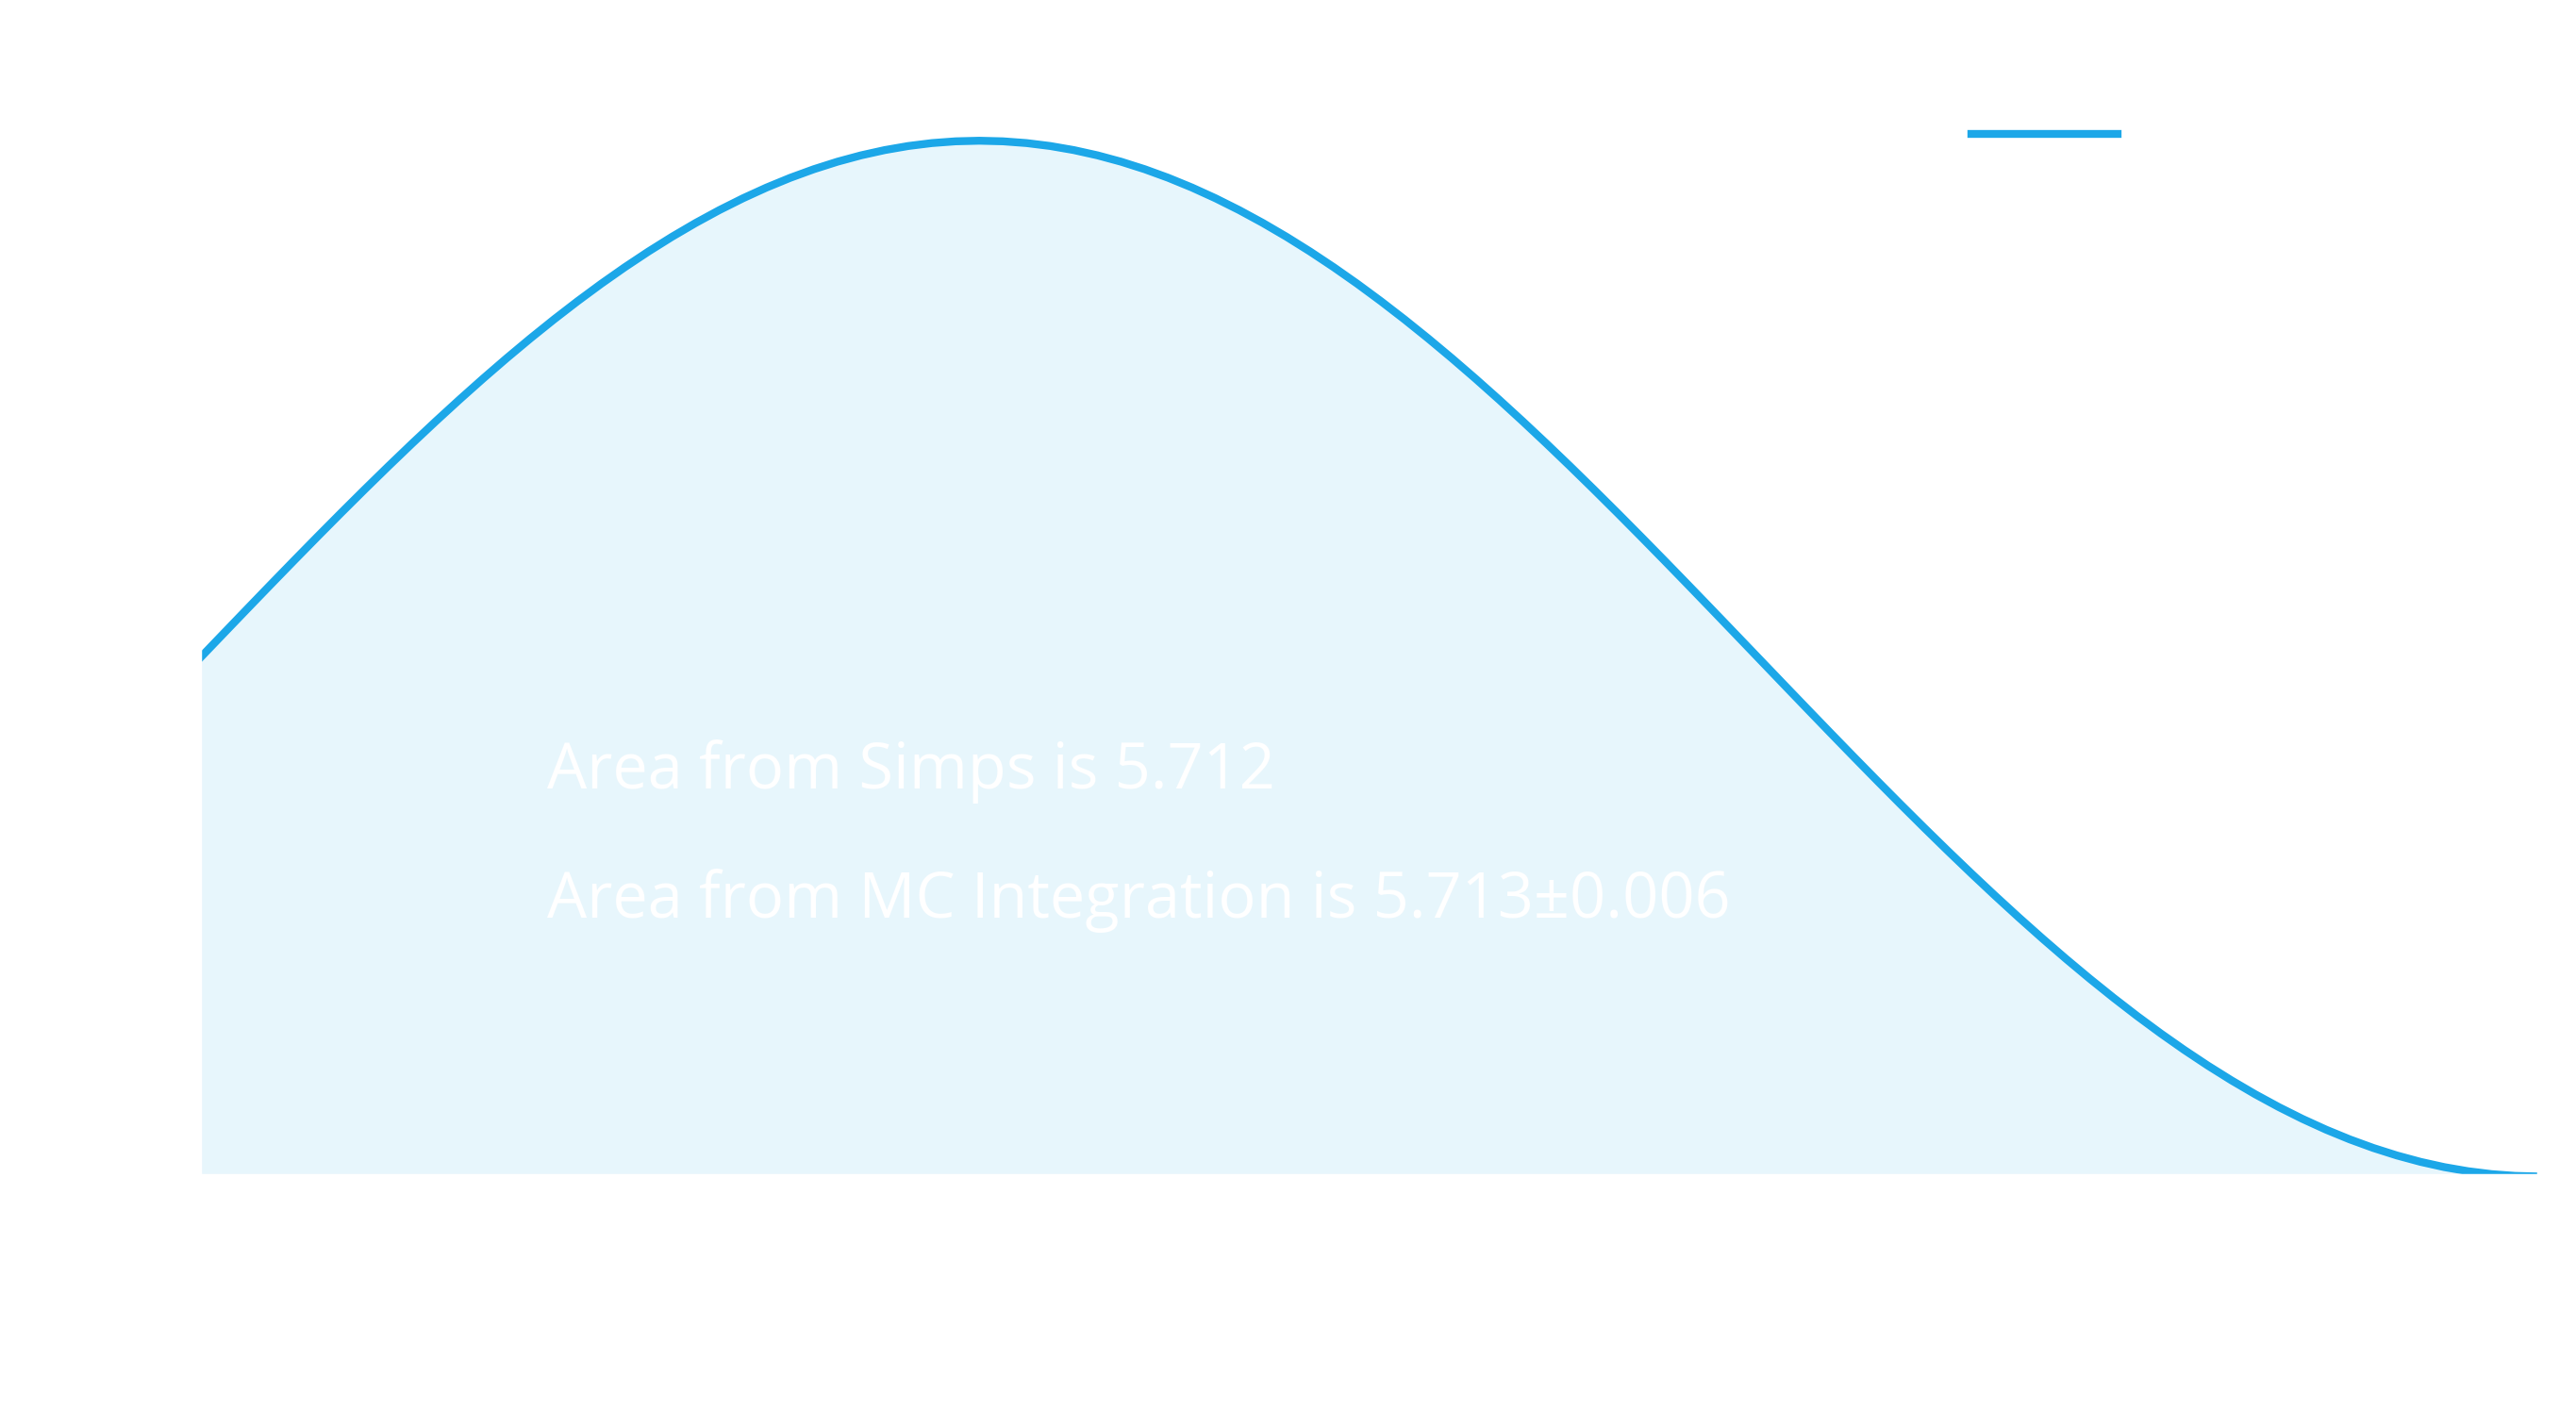

In [6]:
error = np.std(samples * width) / np.sqrt(samples.size)

plt.plot(xs, ys, label="Function")
plt.fill_between(xs, 0, ys, alpha=0.1)
plt.text(0.7, 0.75, f"Area from Simps is {area:0.3f}", fontsize=12)
plt.text(0.7, 0.5, f"Area from MC Integration is {mc_area:0.3f}±{error:0.3f}", fontsize=12)
plt.xlabel("x"), plt.legend();
plt.ylim(0, 2.2); ###REMOVE

Of course, Simpsons' rule has error too, let's not forget that!

## Importance sampling!

Importance sampling is the way that we can improve the accuracy of our estimates. It's conceptually simple - in the plot above, we could get better accuracy if we estimated the peak between 1 and 2 more throughly than if we estimated the area after 4 more thoroughly. So why are we uniformly sampling our distribution, when some areas are much more important??

For a super easy example, lets change the function. We now care about

$$\int_{-\infty}^{\infty} \frac{1 + x^2}{\sqrt{2\pi}} e^{-x^2/2}\ dx.$$

Uniformly sampling this would be crazy - how can we sample from $-\infty$ to $\infty$??? Instead, what we do is we look at the function and we separate it out. We say, "Hey, this looks like a polynomial times a normal distribution". Or more formally:

$$\int_{-\infty}^{\infty} (1+x^2) \ \ \mathcal{N}(0, 1)\ dx,$$

where $\mathcal{N}(0,1)$ is a normal distribution, centered at 0, with a width of 1. And just like before, we now have two parts - the first part to calculate, and the second part we can sample from. To do this, and then create a plot showing each sample, is simple:

In [7]:
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#32a840', '#dbce1a', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))
np.random.seed(2)

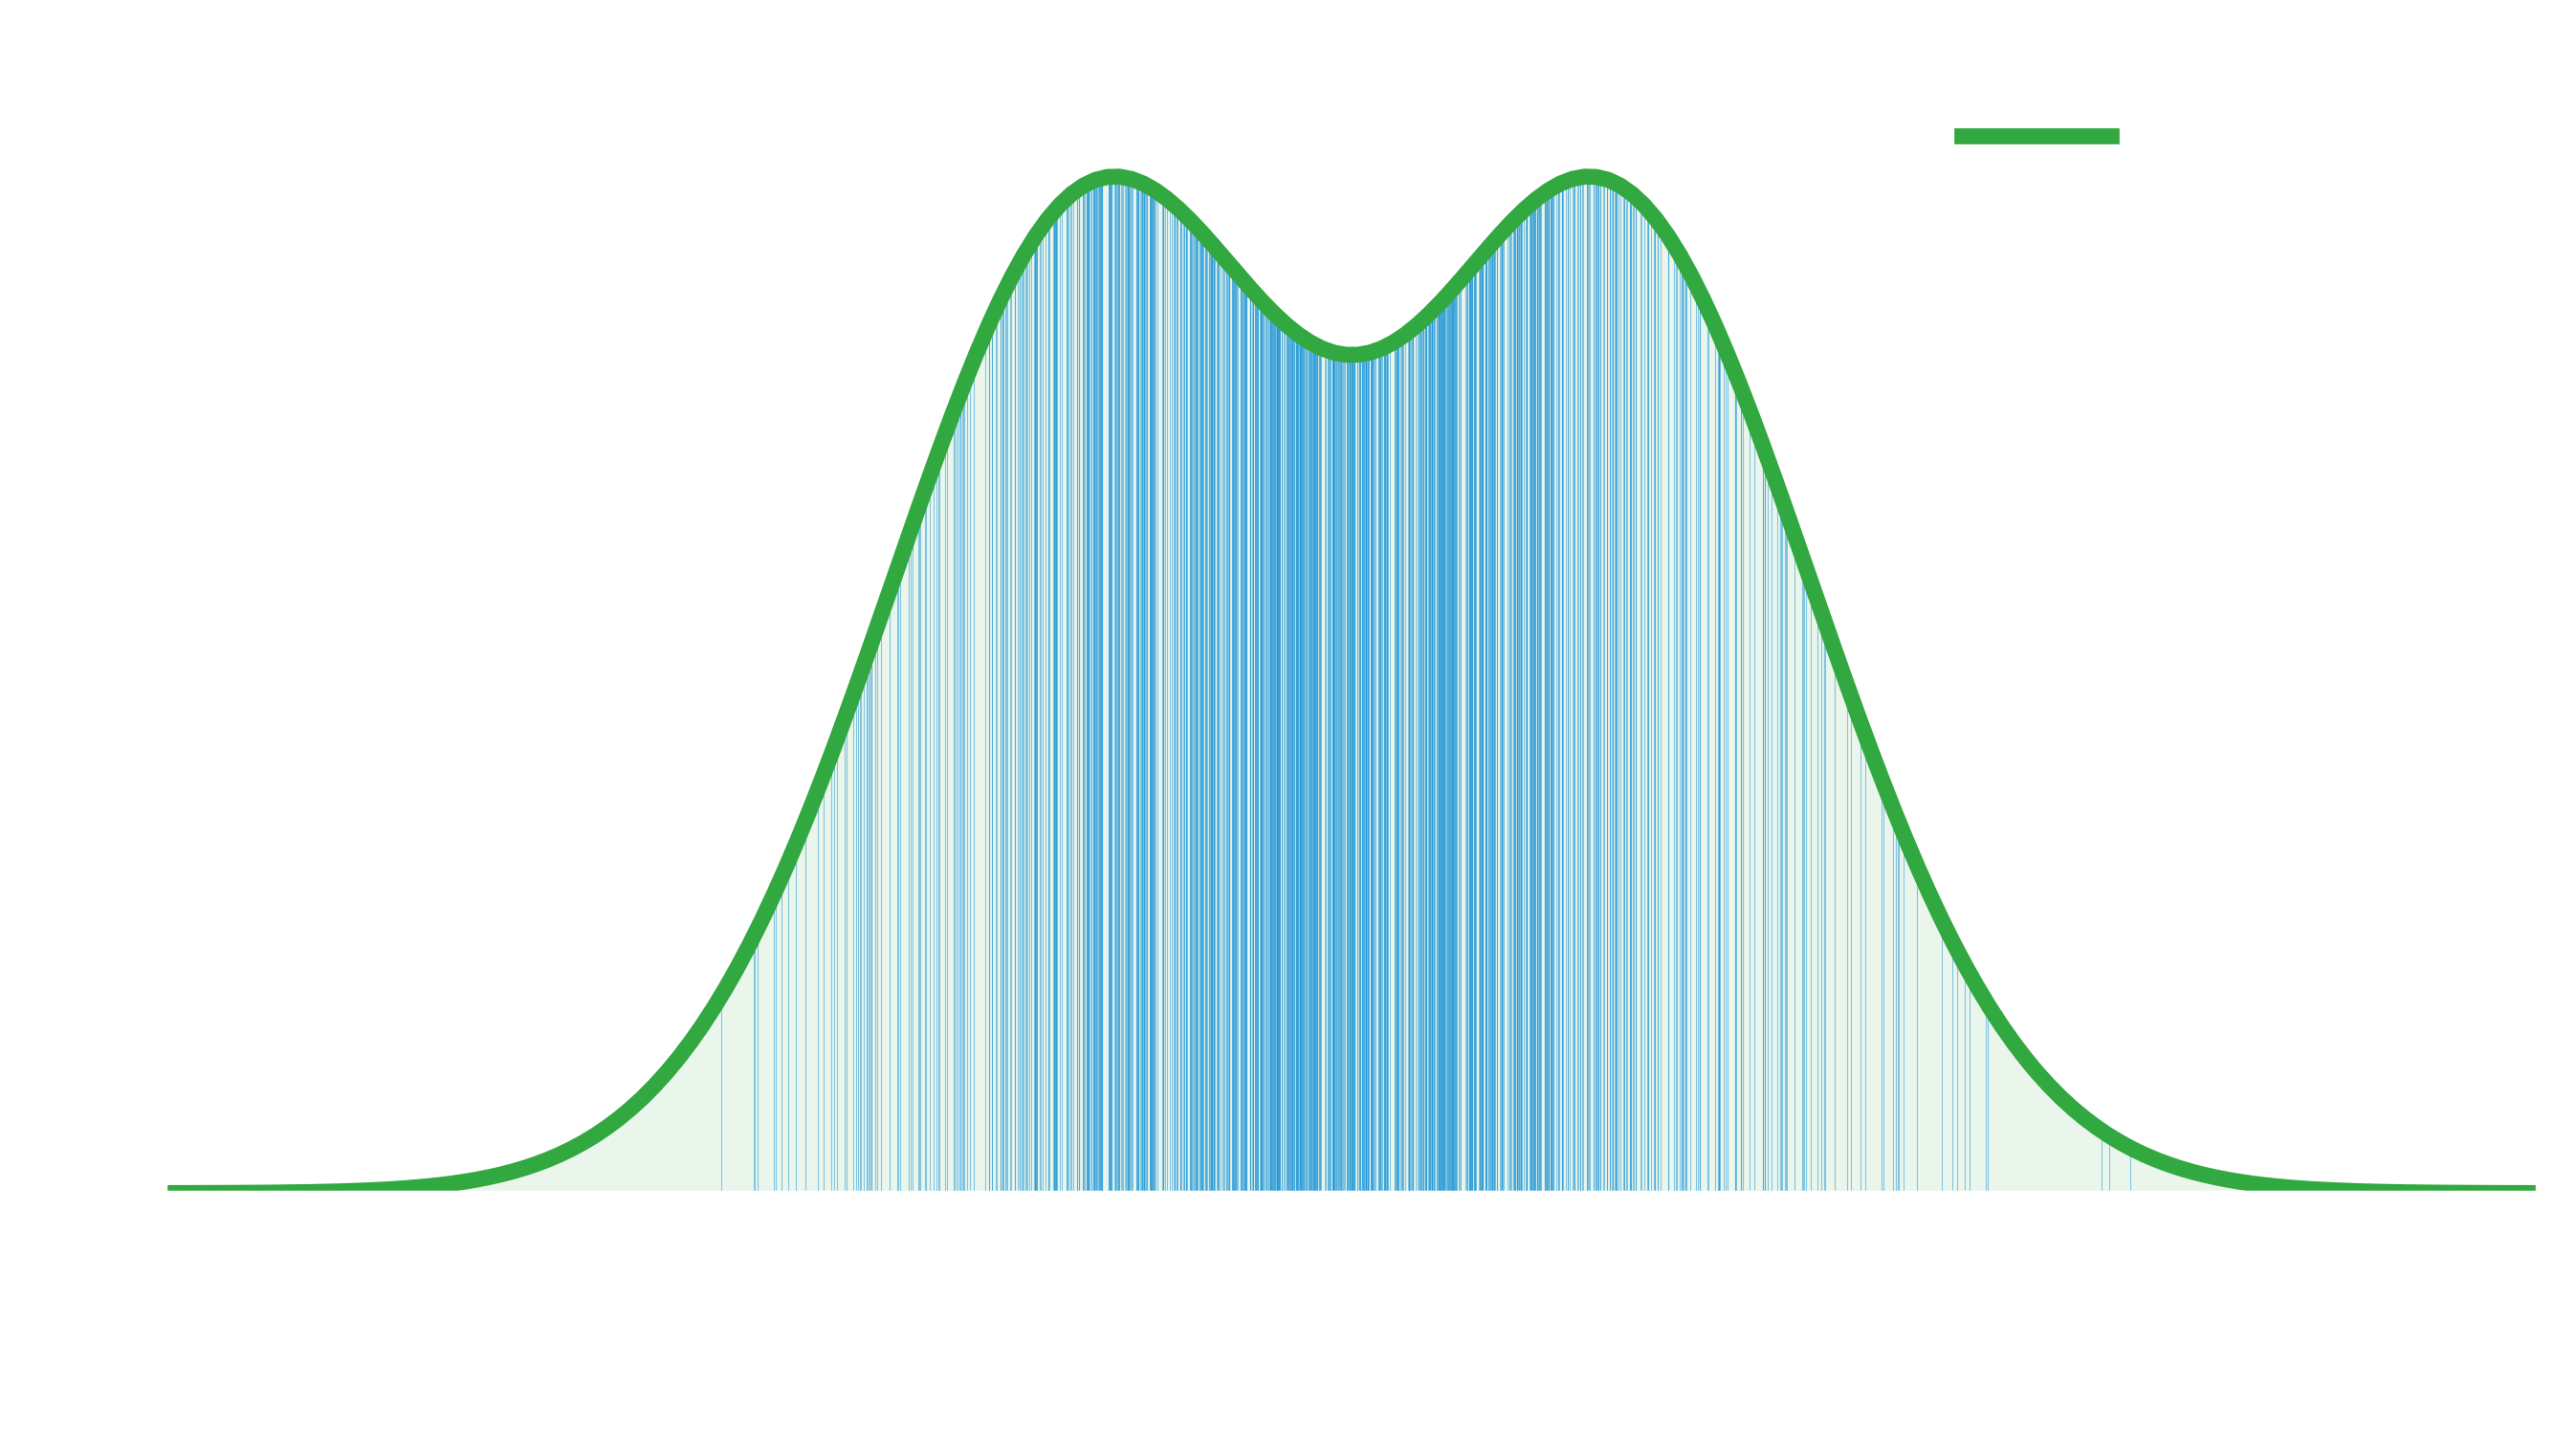

In [8]:
# MC integration here
samples_2 = np.random.normal(size=1000)
fn_2 = 1 + samples_2 ** 2
area_2 = fn_2.mean()
error_2 = np.std(fn_2) / np.sqrt(fn_2.size)

# Simps integration here
def fn2(xs):
    return (1 + xs**2) * np.exp(-(xs**2)/2) / np.sqrt(2 * np.pi)
xs = np.linspace(-5, 5, 200)
ys = fn2(xs)
area_simps = simps(ys, x=xs)

# And of course, plotting here
plt.plot(xs, ys, label="Function", lw=3)
plt.fill_between(xs, 0, ys, alpha=0.1)
plt.text(-4.8, 0.5, f"MC Area={area_2:0.2f}±{error_2:0.2f}", fontsize=12)
plt.text(-4.8, 0.43, f"Simps Area={area_simps:0.2f}", fontsize=12)
plt.plot((samples_2, samples_2), ([0 for i in samples_2], [fn2(i) for i in samples_2]), 
         c='#1c93e8', lw=0.2, ls='-', zorder=-1, alpha=0.5)
plt.xlabel("x"), plt.legend();
plt.ylim(0, 0.55); ###REMOVE

!!! img-main

Where each blue horiztonal line shows us one specific sample.
You can see that for us to get close to Simpons' rule we need far less samples, because we're sampling more efficiently.

When using importance sampling, note that you don't need to have a probability function you can sample with *perfectly* in your equation. You can put any PDF in (just like we did with the uniform distribution), and simply divide the original equation by that PDF. Imaging if we changed our function from above just a tiny bit:

$$\int_{-\infty}^{\infty} \frac{1 + x^2}{\sqrt{2\pi}} e^{-x^4/4}\ dx.$$


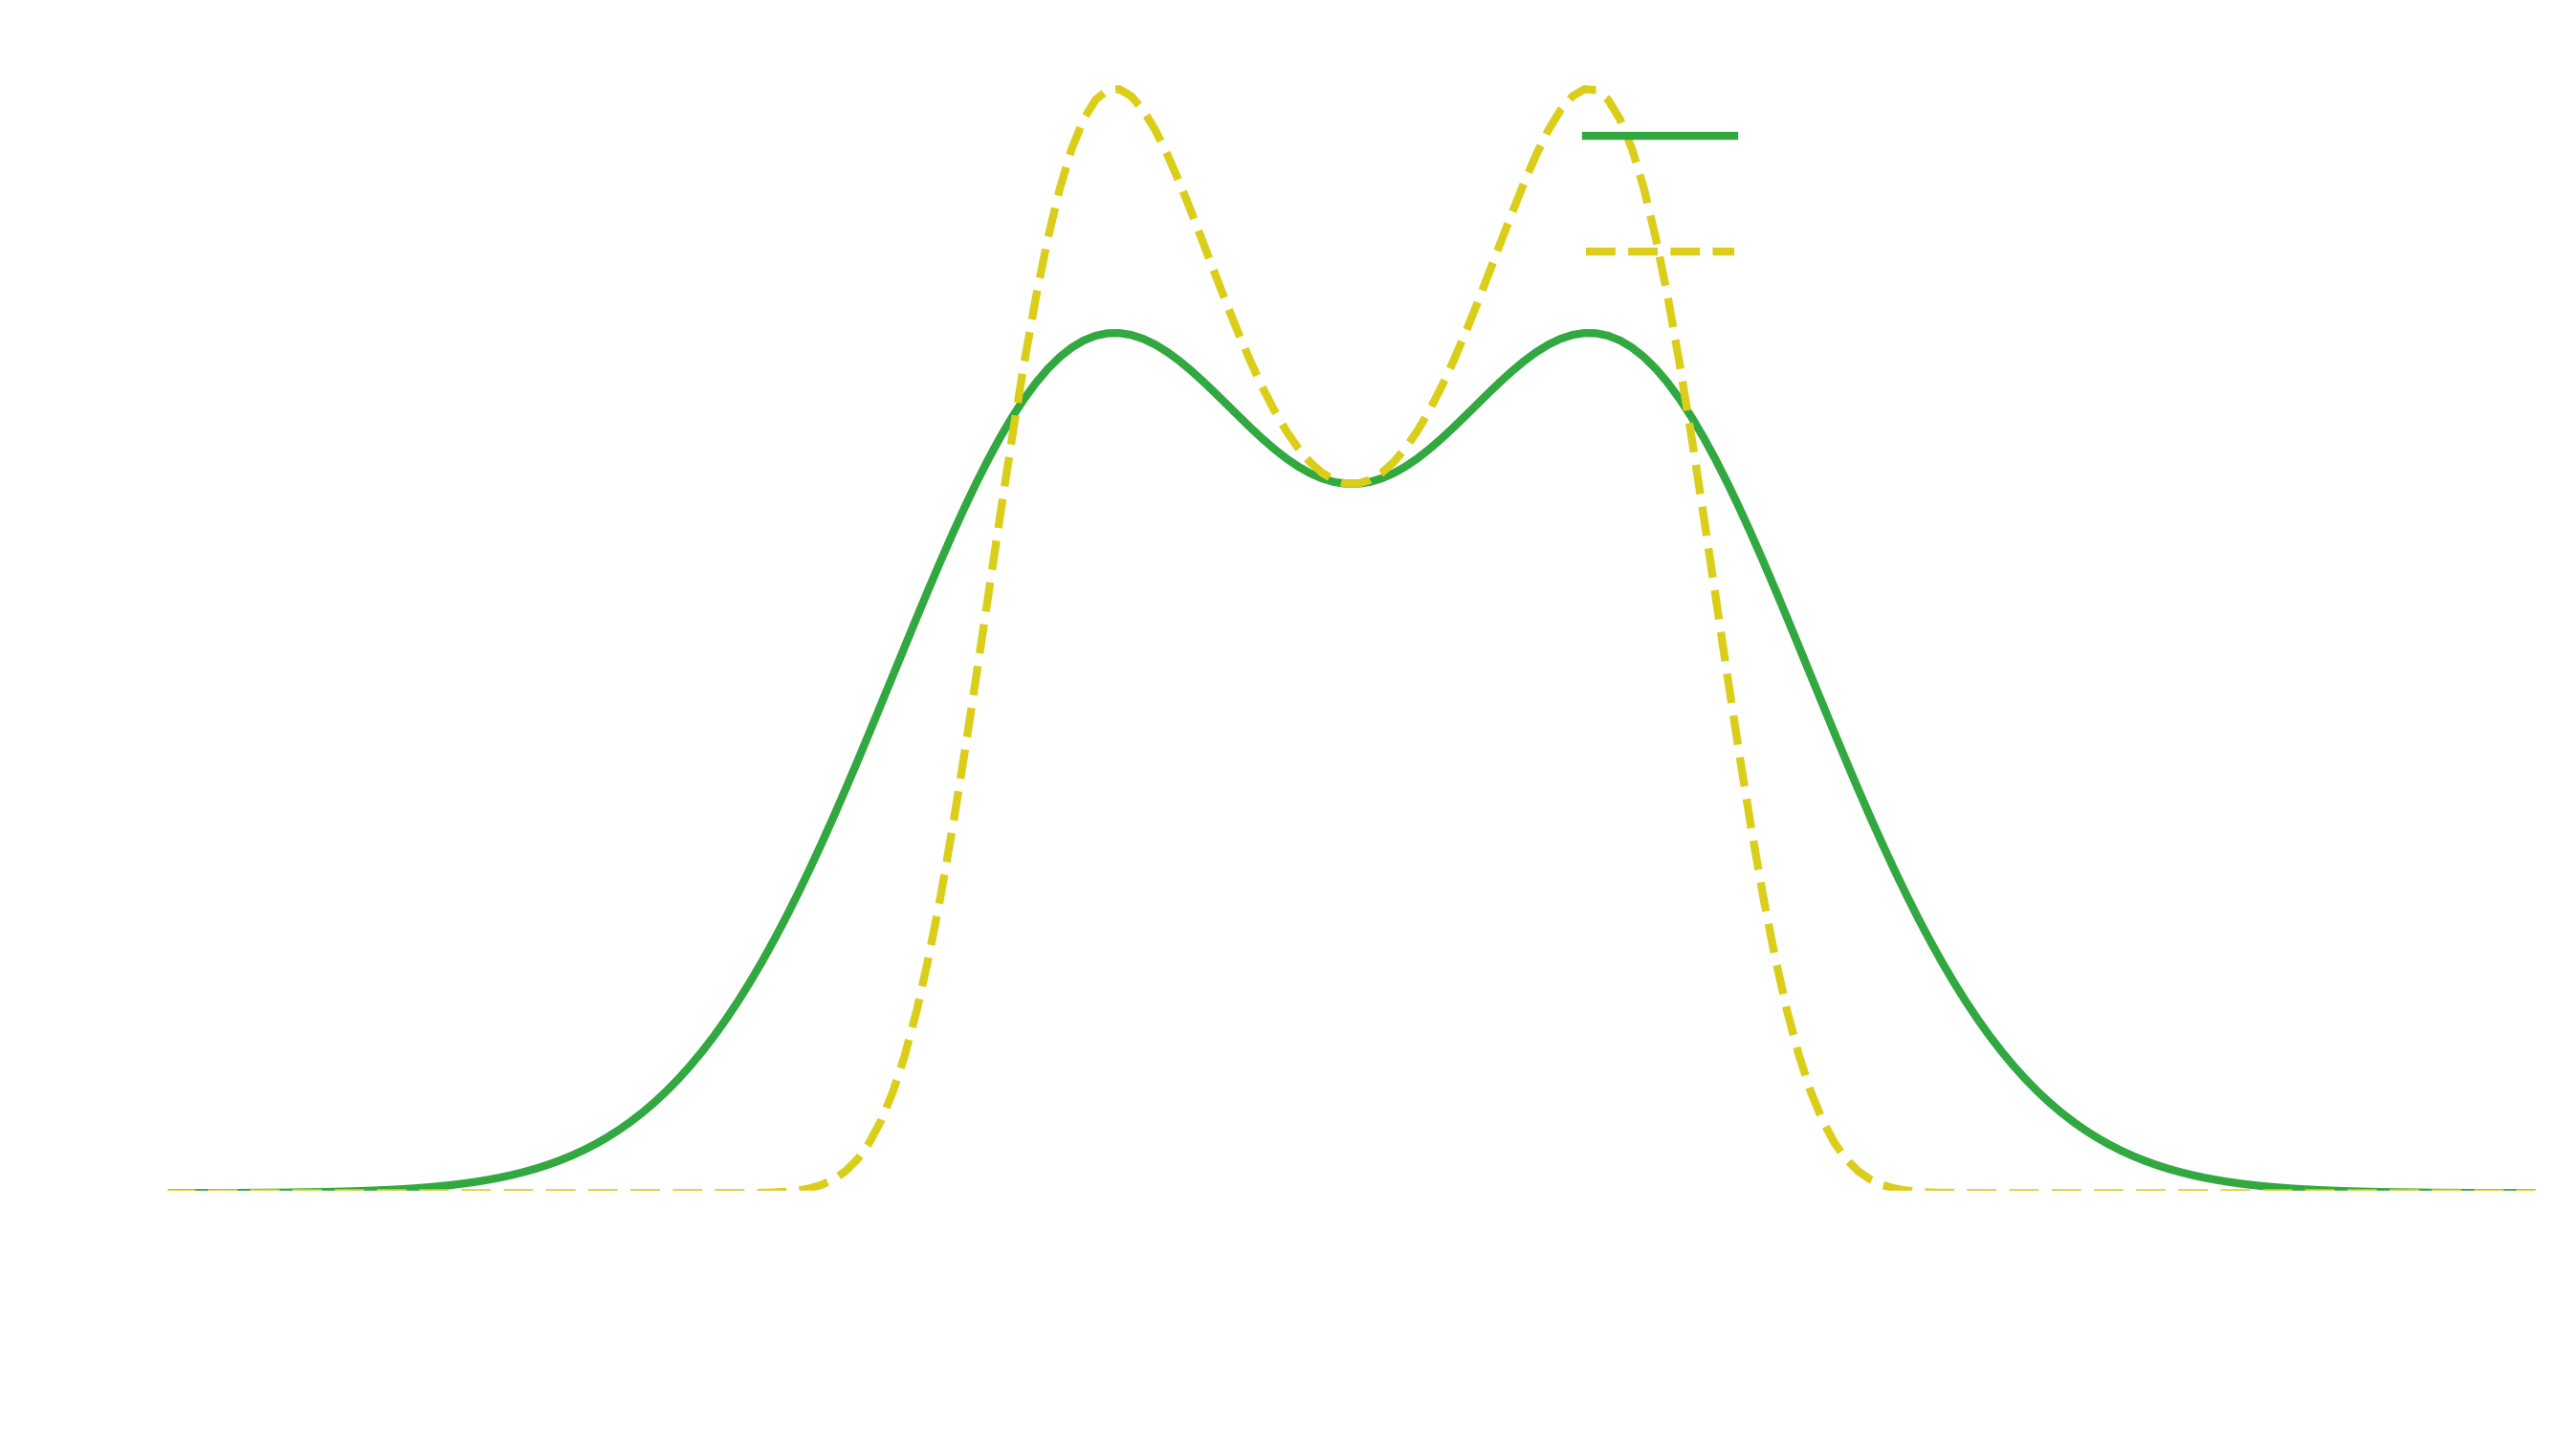

In [9]:
def fn3(xs):
    return (1 + xs**2) * np.exp(-(xs**4)/4) / np.sqrt(2 * np.pi)

ys3 = fn3(xs)
plt.plot(xs, ys, label="Original")
plt.plot(xs, ys3, label="Modified to be $x^4/4$")
plt.legend(); plt.xlabel("x");
plt.ylim(0, 0.65); ###REMOVE

That's fine! We can still use that normal distribution from before, we just add it into the equation. Normally, your function will not be nice and analytic like the one we've tried to use, so we can state in general:

$$\begin{align} \text{integral} &= \int_{-\infty}^{\infty} f(x) dx\\
&= \frac{f(x)}{p(x)} \ p(x) \ dx\\
\end{align}$$


where $p(x)$ in our example will be the normal distribution.

In [10]:
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#e81c1c', '#e89a1c', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))
np.random.seed(2)

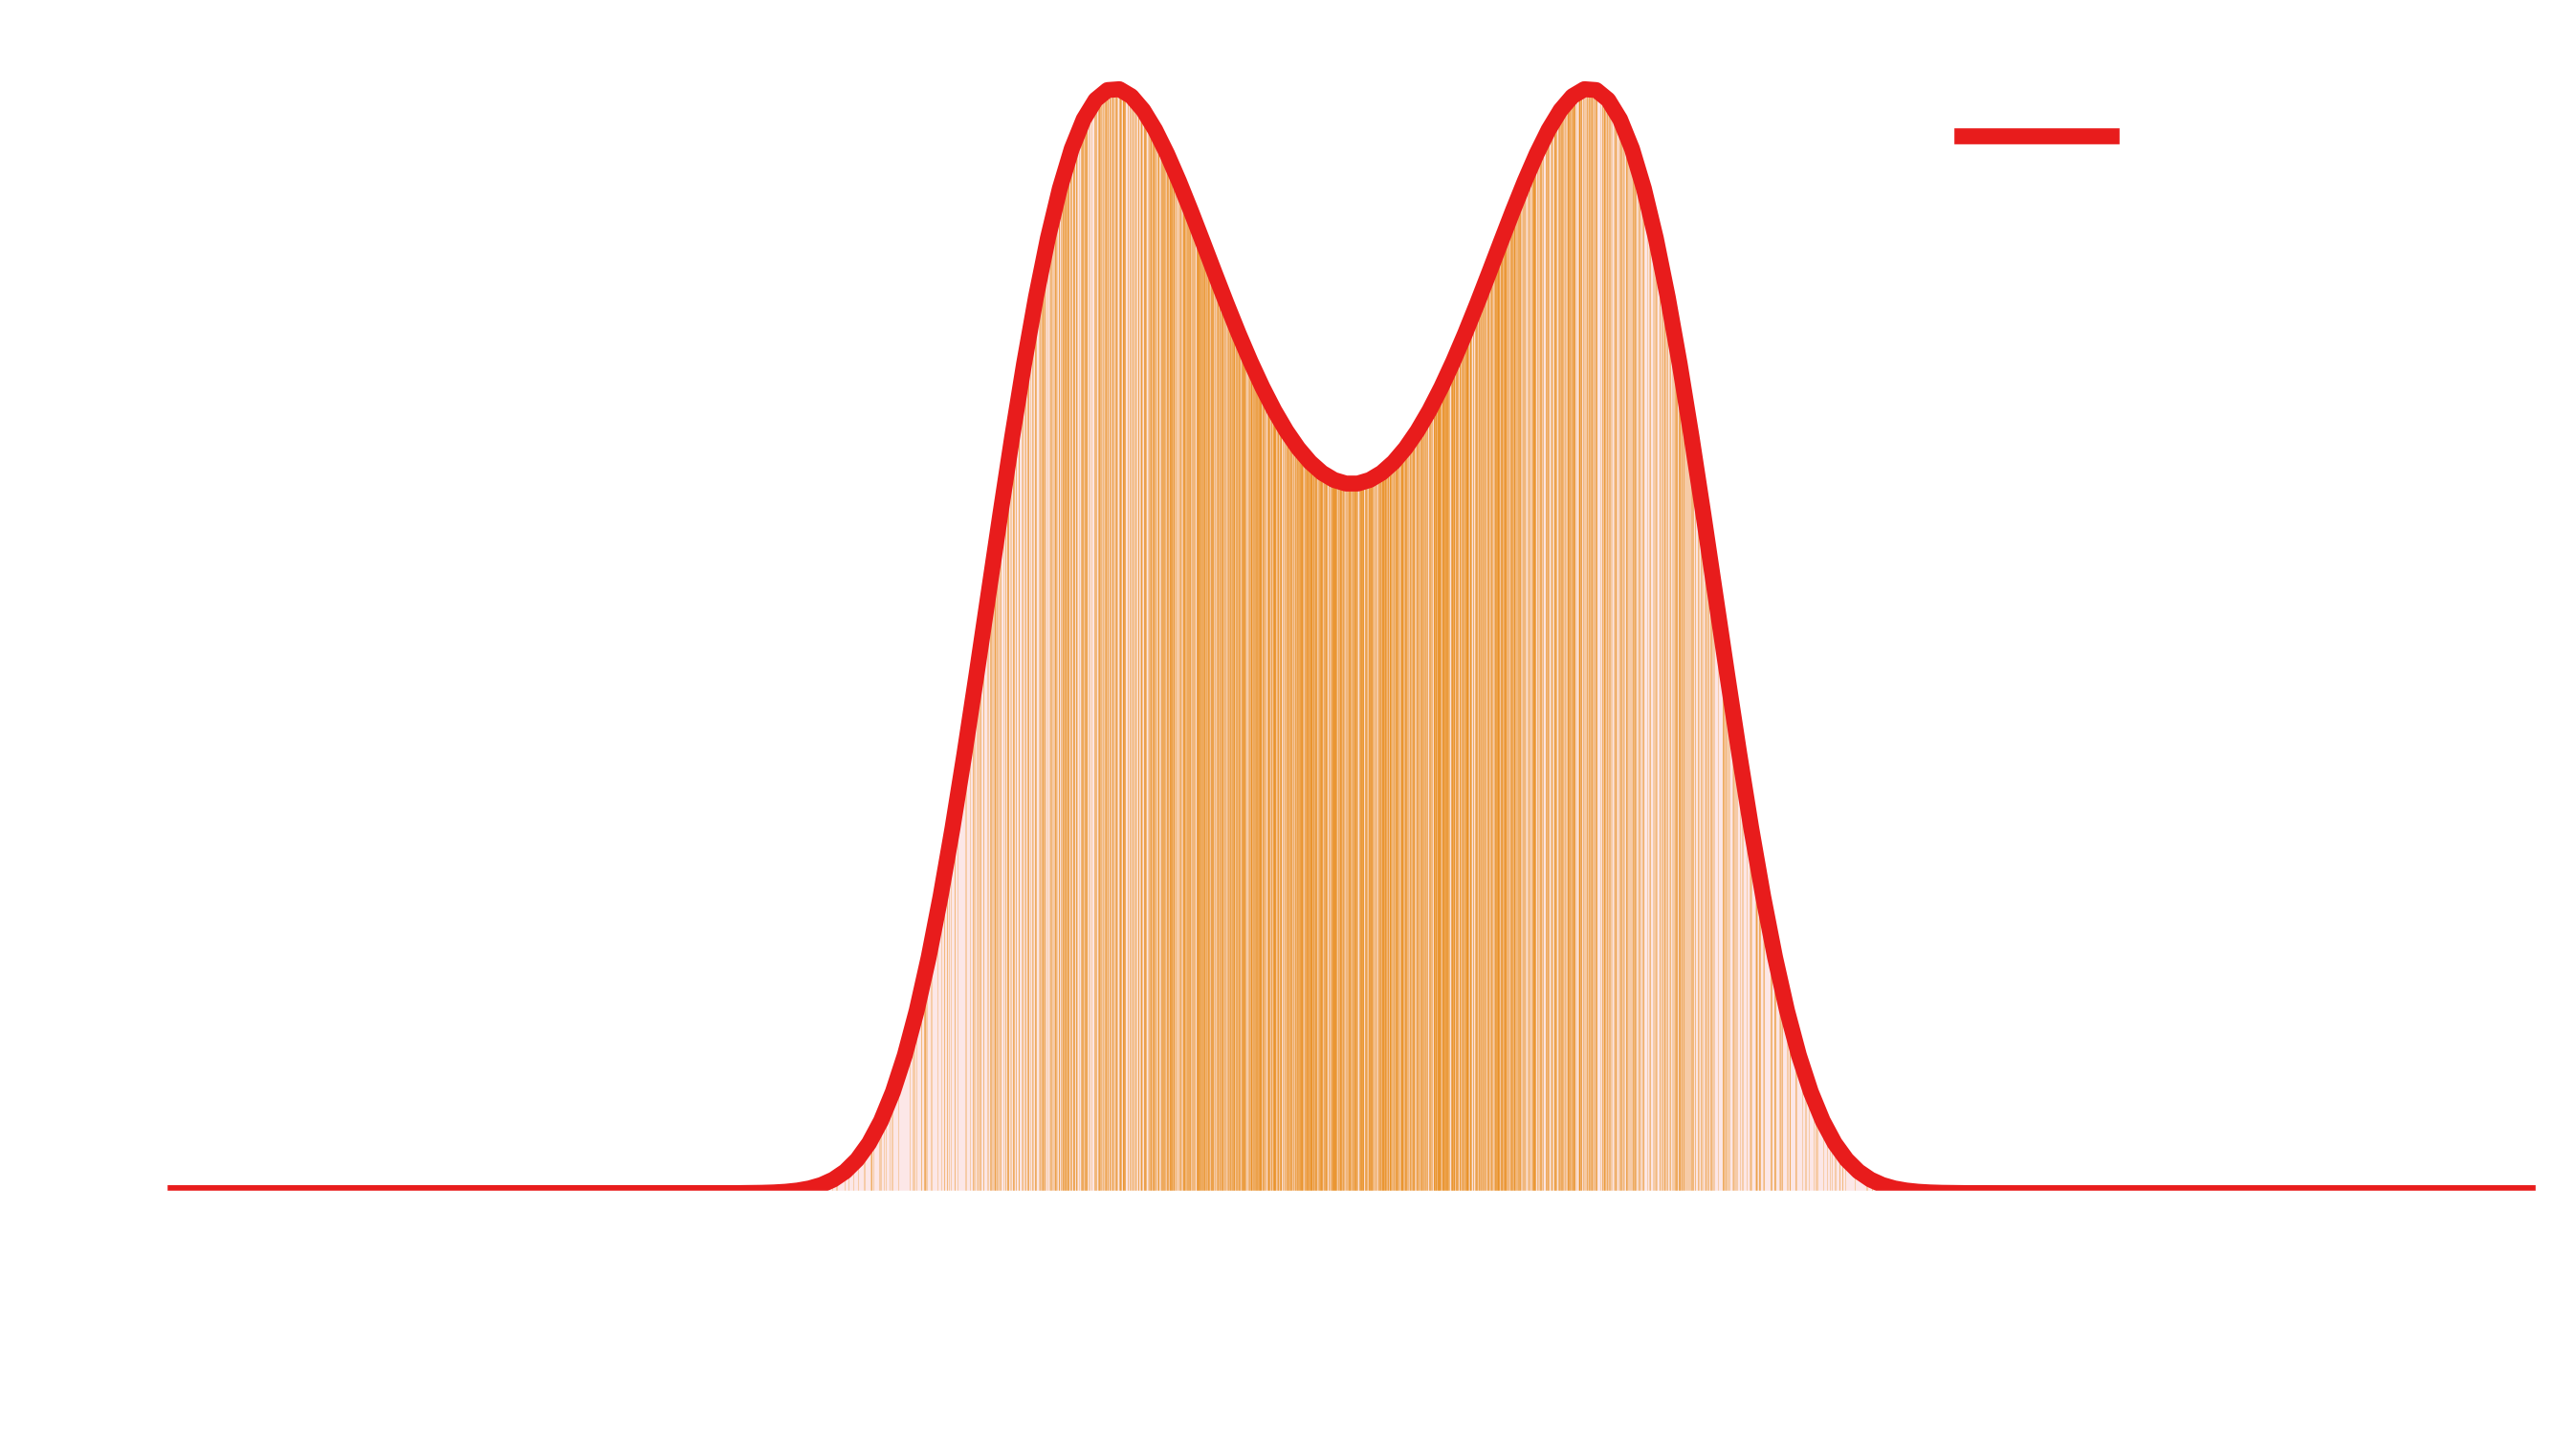

In [15]:
from scipy.stats import norm

# MC integration here
x_samp = norm.rvs(size=2000)
p_of_x = norm.pdf(x_samp)
vals = fn3(x_samp) / p_of_x
area = vals.mean()
error = np.std(vals) / np.sqrt(vals.size)

# Simps integration here
xs = np.linspace(-5, 5, 200)
ys = fn3(xs)
area_simps = simps(ys, x=xs)

# And of course, plotting here
plt.plot(xs, ys, label="Function", lw=3)
plt.fill_between(xs, 0, ys, alpha=0.1)
plt.text(-4.8, 0.5, f"MC Area={area:0.2f}±{error:0.2f}", fontsize=12)
plt.text(-4.8, 0.43, f"Simps Area={area_simps:0.2f}", fontsize=12)
plt.plot((x_samp, x_samp), ([0 for i in x_samp], [fn3(i) for i in x_samp]), 
         c='#e89a1c', lw=0.2, ls='-', zorder=-1, alpha=0.3)
plt.xlabel("x"), plt.legend();
plt.ylim(0, 0.65); ###REMOVE

So hopefully you can see how this would be useful. To summarise, the general process for Monte-Carlo integration is:

1. Have your function to integrate. 1D, 2D, 3D, doesn't matter.
2. Pick a distribution that looks *something* like your function, or just use a Uniform distribution
3. Sample points from that distribution
4. Get the function at those points, and divide by $p(x)$.
5. Take the mean for the estimate, and the standard deviation / root(N) for the error.
6. Celebrate

Finally, obviously I've kept the examples here to 1D for simplicity, but I really should stress that MC integration shines in higher dimensions. If you have a 10 dimensional function that looks roughly Gaussian (like a normal), you can sample from a 10 dimensional normal, and apply all the same steps above, nothing at all changes. 